# Compare exponential and polynomial fit. Needs tidy up!

We use data from the files at https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

Thank you @CSSEGISandData for providing the data!

In [11]:
%config InlineBackend.figure_formats = ['svg']
import math
from numpy import log, exp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
figsize = (8, 6)   # need bigger size otherwise xlabels are cut-off in svg files

import os
import pandas as pd
import seaborn as sb
sb.set_style('darkgrid')
import scipy
import numpy as np
import iminuit

base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

def string_to_date(input_):
    """Converts string of type 01/22/02 [for 22 Jan 2020] into datetime object"""
    # return pd.to_datetime(input_, format='%m/%d/%y', errors='ignore')
    return pd.to_datetime(input_, format='%m/%d/%y')

def set_date_formatting(ax):
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', rotation=90)

# read data from web
#

def fetch_data(names = ['confirmed', 'deaths']):
    """Return 3 data frames:
    [confirmed, deaths], location_info
    
    where confirmed, deaths and recovered are data frames with countries/regions in the rows, and 
    days in the columns
    
    and location_info provides additional information about the locations.
    
    We assume all three tables have the same entries"""
    location_info = pd.DataFrame()
    dfs = []
    for name in names:
        url = os.path.join(base_url, "time_series_covid19_" + name + "_global.csv")
        df = pd.read_csv(url, index_col=1)
    
        if not name == 'Recovered':
            location_info['Lat'] = df['Lat']
            location_info['Long'] = df['Long']
            location_info['Province/State'] = df['Province/State']
            location_info['location'] = df.index + "-" + df['Province/State']
        else:
            pass  # no location info in recovered since 14 March
        ## df = df.drop(labels=["Lat", "Long", "Province/State"], axis=1)
        df = df.drop(labels=["Lat", "Long"], axis=1)
        
        # extract dates from strings
        dates = string_to_date(df.columns[1:])        
        # use those objects as new column labels
        df.columns = [df.columns[0]] + list(dates)
        print(f"{name:10}: last data point from {max(dates[1:])}")
        # dfs.append([df, location_info)
        dfs.append(df)

    return dfs


confirmed, deaths = fetch_data()

# show counries with mosth deaths
deaths.sort_values(by=deaths.columns[-1], ascending=False).iloc[0:10,-8:]

confirmed : last data point from 2020-03-27 00:00:00
deaths    : last data point from 2020-03-27 00:00:00


,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00
Country/Region,,,,,,,,
Italy,4032,4825,5476,6077,6820,7503,8215,9134
Spain,1043,1375,1772,2311,2808,3647,4365,5138
China,3133,3139,3153,3153,3160,3163,3169,3174
Iran,1433,1556,1685,1812,1934,2077,2234,2378
France,450,562,674,860,1100,1331,1696,1995
US,244,307,417,557,706,942,1209,1581
United Kingdom,177,233,281,335,422,465,578,759
Netherlands,106,136,179,213,276,356,434,546
Germany,67,84,94,123,157,206,267,342


In [12]:
deaths.sort_values(by=deaths.columns[-1], ascending=False).iloc[:,-8:]


,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00
Country/Region,,,,,,,,
Italy,4032,4825,5476,6077,6820,7503,8215,9134
Spain,1043,1375,1772,2311,2808,3647,4365,5138
China,3133,3139,3153,3153,3160,3163,3169,3174
Iran,1433,1556,1685,1812,1934,2077,2234,2378
France,450,562,674,860,1100,1331,1696,1995
...,...,...,...,...,...,...,...,...
Fiji,0,0,0,0,0,0,0,0
Ethiopia,0,0,0,0,0,0,0,0
Eswatini,0,0,0,0,0,0,0,0


In [26]:
def double_time_exponential(t1, t2, q1, q2):
    return (t2 - t1) * (log(2) / log(q2/q1) )

def growth_rate(double_time):
    return log(2)/double_time

def double_time(growth_rate):
    return log(2)/growth_rate


# t1, t2, q1, q2 = 0, 1, 1, 2
# double_time_exponential(t1, t2, q1, q2), growth_rate(double_time_exponential(t1, t2, q1, q2) )

def double_time_exponential(q2_div_q1, t2_minus_t1=None):
    # print(f"double_time_exponential: {q2_div_q1}, {t2_minus_t1} ")
    if t2_minus_t1 is None:
        t2_minus_t1 = np.ones(q2_div_q1.shape)
        # print(f"shape t: {t2_minus_t1.shape}, shape q: {q2_div_q1.shape}")
        # print(f"type t: {type(t2_minus_t1)}, type q: {type(q2_div_q1.shape)}")

    return t2_minus_t1 * np.log(2) / np.log(q2_div_q1) 


def stack_country(country = "Germany"):

    #create one DataFrame for country/region
    c_df = pd.DataFrame()
    if country == "United Kingdom":
        # UK has three Provinces: Channel Islands, Gibraltar and UK. Only need last one
        c_df['confirmed'] = confirmed.loc[country].iloc[-1].drop('Province/State')
        c_df['deaths'] = deaths.loc[country].iloc[-1].drop('Province/State')
    elif country == "China": 
        # Use only Hubei province
        tmp = confirmed.loc[country]
        c_df['confirmed'] = tmp[tmp['Province/State'] == "Hubei"].T['China']
        tmp = deaths.loc[country]
        c_df['deaths'] = tmp[tmp['Province/State'] == "Hubei"].T['China']
        c_df.drop("Province/State", inplace=True)
    elif country in ['US', 'France']:
        c_df['confirmed'] = confirmed.loc[country].sum()
        c_df['deaths'] = deaths.loc[country].sum()
        c_df.drop('Province/State', inplace=True)
    else:
        c_df['confirmed'] = confirmed.loc[country].drop('Province/State')
        c_df['deaths'] = deaths.loc[country].drop('Province/State')

    # drop days with confirmed cases = 0
    c1 = c_df[c_df['confirmed'] != 0][1:]
    
    # drop another row
    c_df = c1
  
    c_df.index = string_to_date(c_df.index)
    c_df.country = country  # remember which country we work on, just in case
    
    c_df['days-td'] = c_df.index - c_df.index.min()  # days as TimeDelta type
    c_df['days'] = c_df['days-td'].astype("timedelta64[D]").astype(float)
    
    c_df['new_confirmed'] = c_df['confirmed'].diff()
    c_df['new_deaths'] = c_df['deaths'].diff()
    
    c_df['confirmed_pct'] = c_df['confirmed'].pct_change()+1
    c_df['deaths_pct'] = c_df['deaths'].pct_change()+1
    
    #return c_df
    # growth rate
    c_df['deaths_double_time'] = double_time_exponential(c_df['deaths_pct'].values)
    c_df['confirmed_double_time'] = double_time_exponential(c_df['confirmed_pct'].values)
    c_df['deaths_growth_rate'] = growth_rate(c_df['deaths_double_time'].values)
    c_df['confirmed_growth_rate'] = growth_rate(c_df['confirmed_double_time'].values)

    return c_df

In [14]:

c = stack_country("Germany")
#c.tail(n=5)
c2 = stack_country("United Kingdom")
#c.tail(n=5)
#c2 = stack_country("Spain")
#c.tail(n=5)
#c2 = stack_country("Italy")
#c2.tail(n=5)
#c2 = stack_country("France")
#c2.tail(n=5)
#c2 = stack_country("China")
#c2 = stack_country("US")

c

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


,confirmed,deaths,days-td,days,new_confirmed,new_deaths,confirmed_pct,deaths_pct,deaths_double_time,confirmed_double_time,deaths_growth_rate,confirmed_growth_rate
2020-01-28,4,0,0 days,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,4,0,1 days,1.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-01-30,4,0,2 days,2.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-01-31,5,0,3 days,3.0,1,0,1.250000,NaN,NaN,3.106284,NaN,0.223144
2020-02-01,8,0,4 days,4.0,3,0,1.600000,NaN,NaN,1.474770,NaN,0.470004
2020-02-02,10,0,5 days,5.0,2,0,1.250000,NaN,NaN,3.106284,NaN,0.223144
2020-02-03,12,0,6 days,6.0,2,0,1.200000,NaN,NaN,3.801784,NaN,0.182322
2020-02-04,12,0,7 days,7.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-02-05,12,0,8 days,8.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000
2020-02-06,12,0,9 days,9.0,0,0,1.000000,NaN,NaN,inf,NaN,0.000000


In [15]:
def overview_plot(c_df):
    fig, axes = plt.subplots(3, 1, figsize=(8, 14))
    ax = axes[0]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['confirmed'], 'o-b', label='confirmed')
    ax.plot(c_df.index, c_df['deaths'], 'o-r', label='deaths')
    ax.legend(loc='center left')
    country = c_df.country
    ax.set_title(country + " accumulated data")
    ax.set_yscale('log')
    
    ax = axes[1]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['deaths_double_time'], 'xr', label='double time deaths')
    ax.plot(c_df.index, c_df['confirmed_double_time'], 'ob', label='double time confirmed')
    ax.legend(loc='center left')
    ax.set_ylabel('days to double numbers \n bigger is better')
    maxy = min(10, max(c_df['confirmed_double_time']))
    ax.set_ylim(0, maxy)

    ax = axes[2]
    set_date_formatting(ax)
    ax.plot(c_df.index, c_df['deaths_growth_rate'], 'xr', label='growth rate deaths')
    ax.plot(c_df.index, c_df['confirmed_growth_rate'], 'ob', label='confirmed growth rate')
    ax.legend(loc='center left')
    ax.set_ylim(0, 0.5)
    ax.set_ylabel('growth rate r in\n f(t) = exp(r*t)\n(smaller is better)')
    
    # fig.savefig(f"figures/{country}-overview.svg")
    return axes

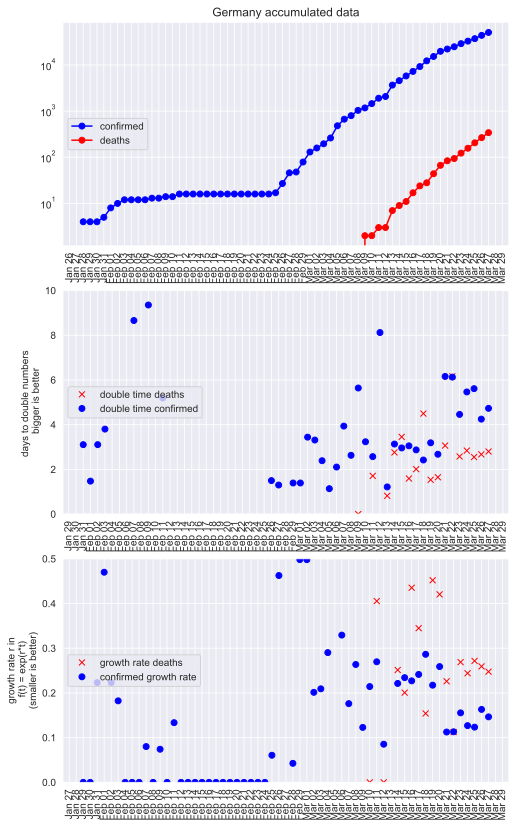

In [16]:
overview_plot(c);

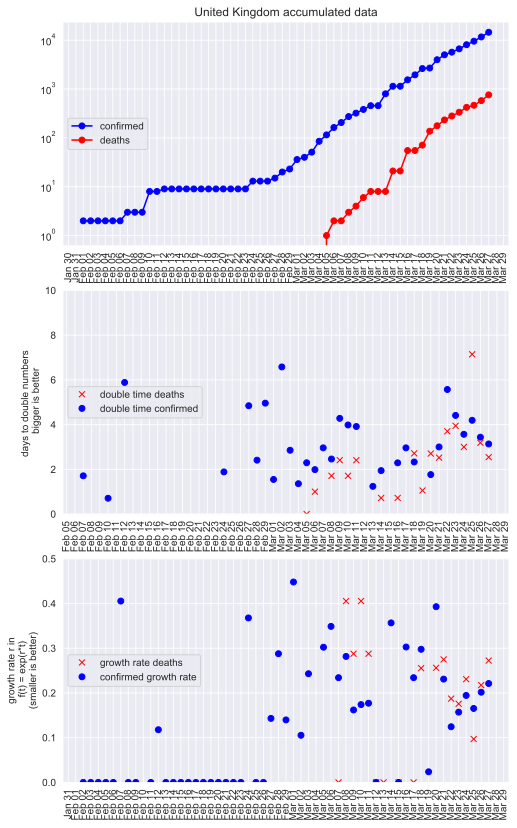

In [17]:
overview_plot(c2);

In [18]:
# compute doubling time (and growth rate) for a longer sequence of days (by fitting)


reduced chi^2: 0.009228711301896989
r   : 0.0562
t0  : -27.8
a0  : -3.12



------------------------------------------------------------------
| FCN = 0.009229                |     Ncalls=212 (212 total)     |
| EDM = 4.97E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | r    |   0.06    |   0.05    |            |            |         |         |       |
| 1 | t0   |    -28    |     58    |            |            |         |         |       |
| 2 | a0   |   -3.1    |    11.2   |            |            |         |         |       |
------------------------------------------------------------------------------------------

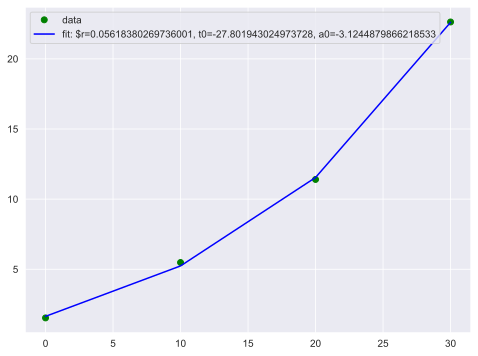

In [19]:
def pretty_params(**par):
    end='\n'
    s = ""
    for p in par:
        s += f"{p:3} : {par[p]:.3g}" + end
    return s


def model(xdata, r, t0, a0):
    return np.exp(r*(xdata-t0))+a0



def exp_fit(xdata, ydata, p0):
    r, t0, a0 = p0
    
    def least_squares(r, t0, a0):
        yvar = 10
        return sum((ydata - model(xdata, r, t0, a0))**2)/yvar
    
    m = iminuit.Minuit(least_squares, 
                       r=r, t0=t0, a0=a0, error_r=0.02, error_t0=0.2, error_a0=1, 
                       errordef=1)
    res = m.migrad()
    print(f"reduced chi^2: {m.fval / (len(ydata) - 3)}")
    r, t0, a0 = m.np_values()
    print(pretty_params(r=r, t0=t0, a0=a0))
    
    return m, res

def plot(xdata, ydata, r, t0, a0, annotate=""):
    #r, t0, a0 = m.np_values()

    fitted = model(xdata, r, t0, a0)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(xdata, ydata, 'og')
    ax.plot(xdata, fitted, '-b')
    ax.legend(["data", f"fit: $r={r}, t0={t0}, a0={a0}"])
    #ax.set_title(f"Infections $n(t)$ ({pretty_params(param_infections, end=', ')})")
    ax.set_title(annotate)
    #ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    #ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    #ax.tick_params(axis='x', rotation=90)
    #fig.savefig('figures/infections-with-model-fit.svg')
    # print(fitted_infections)
    return ax

def test_model(): 
    xdata = np.linspace(0, 30, 4)
    ydata = 0 + np.exp(0.1*(xdata - 0)) + 5*np.random.random_sample(xdata.shape)    
    m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
    r, t0, a0 = m.np_values()
    plot(xdata, ydata, r, t0, a0)
    return res, m, xdata, ydata


res, m, xdata, ydata = test_model()
res


reduced chi^2: 71744.33598741457
r   : 0.119
t0  : -32.7
a0  : -6.01e+03

Double time: 5.8 days


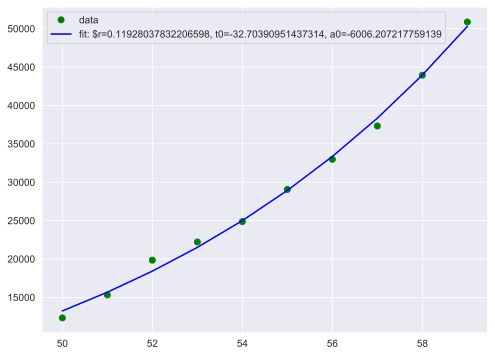

In [32]:
# Exponential fit through last n days
series = c['confirmed']
start = -10
end = None
xdata_0 = (series.index[start:end] - series.index[0])
xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
ydata = series.values[start:end]
# Attempt fit
m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
r, t0, a0 = m.np_values()
plot(xdata, ydata, r, t0, a0)
print(f"Double time: {double_time(r):.1f} days")


reduced chi^2: 3.2589124199944624
r   : 0.25
t0  : 35.7
a0  : -0.641

Double time: 2.8 days


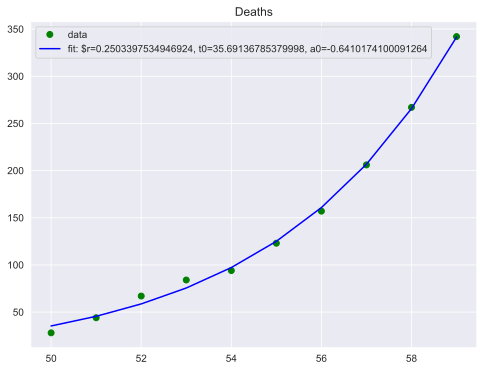

In [33]:
# Exponential fit through last n days, deaths
series = c['deaths']
start = -10
end = None
xdata_0 = (series.index[start:end] - series.index[0])
xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
ydata = series.values[start:end]
# Attempt fit
m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
r, t0, a0 = m.np_values()
ax = plot(xdata, ydata, r, t0, a0)
ax.set_title("Deaths")
print(f"Double time: {double_time(r):.1f} days")


In [34]:
def grow_rate_n_days(series, n=5):
    """Use the last 4 data points to estimate growth rate (and doubling time) for each day"""
    par = pd.DataFrame(index=series.index, columns=['r', 't0', 'a0', 'chi2'])
    print(f"Data stack shape = {series.shape}")
    for i in range(n, len(series)):
        start = i-n
        end = i
        print(f"Working on {start} to {end}, this is {start}/{len(series-n)}")
        xdata_0 = (series.index[start:end] - series.index[0])
        xdata = np.array((xdata_0.astype("timedelta64[D]").astype(float)))
        ydata = series.values[start:end]
        # Attempt fit
        m, res = exp_fit(xdata, ydata, (.1, 0.00, 0.0))
        r, t0, a0 = m.np_values()
        par.iloc[i].at['r'] = r
        par.iloc[i].at['t0'] = t0
        par.iloc[i].at['a0'] = a0
        print(f"r={r:10}, t0={t0:10}, a0={a0:10}")
        plot(xdata, ydata, r, t0, a0)
            
    return par

/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/fangohr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Data stack shape = (20,)
Working on 0 to 5, this is 0/20
reduced chi^2: 1099.516019676374
r   : 0.103
t0  : -74.7
a0  : -1.21e+03

r=0.10302349301253391, t0=-74.72755764233851, a0=-1207.160407312009
Working on 1 to 6, this is 1/20
reduced chi^2: 5521.59768462258
r   : 0.841
t0  : -4.26
a0  : 1.22e+03

r=0.8412893243724417, t0=-4.259280511396165, a0=1222.1293987159756
Working on 2 to 7, this is 2/20
reduced chi^2: 12884.774534924796
r   : 0.384
t0  : -15.7
a0  : 515

r=0.38415422579342323, t0=-15.691829121496719, a0=514.9278436189372
Working on 3 to 8, this is 3/20
reduced chi^2: 13987.587903629497
r   : 0.173
t0  : -45.2
a0  : -2.42e+03

r=0.17278422599950122, t0=-45.20681653988109, a0=-2422.446193914924
Working on 4 to 9, this is 4/20
reduced chi^2: 5391.980565174457
r   : 0.0274
t0  : -385
a0  : -4.09e+04

r=0.027446088288995443, t0=-384.82115610490445, a0=-40901.60069762569
Working on 5 to 10, this is 5/20
reduced chi^2: 51.33890989812337
r   : 0.253
t0  : -26.8
a0  : 498

r=0.25329

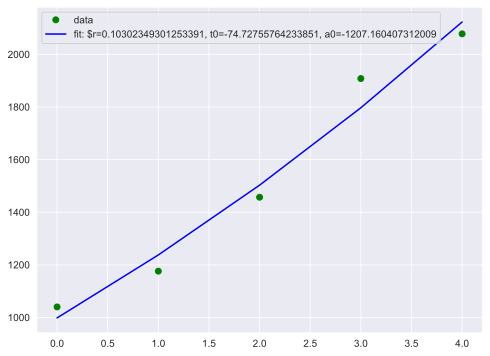

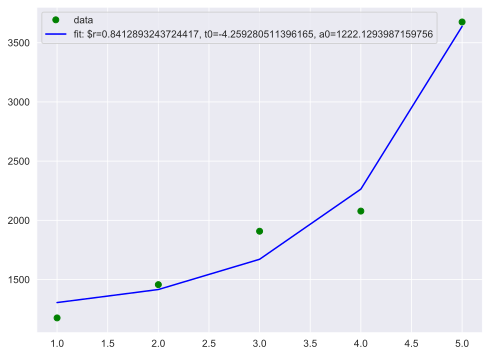

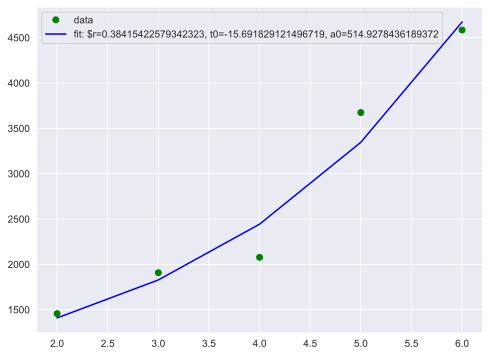

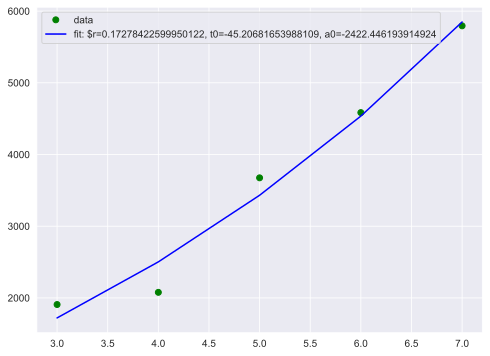

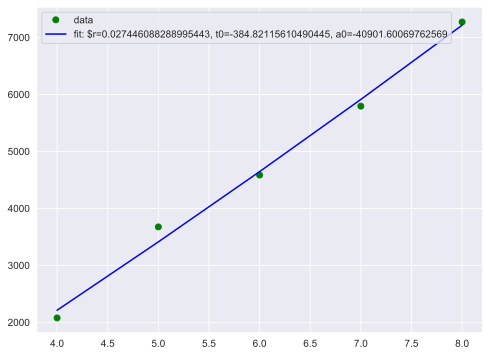

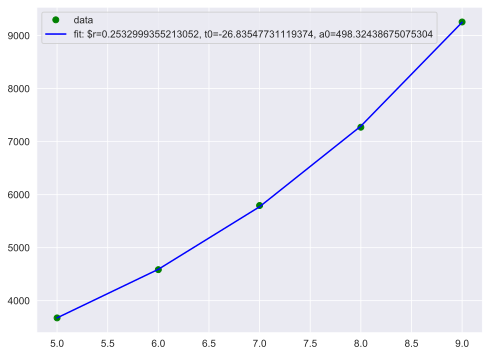

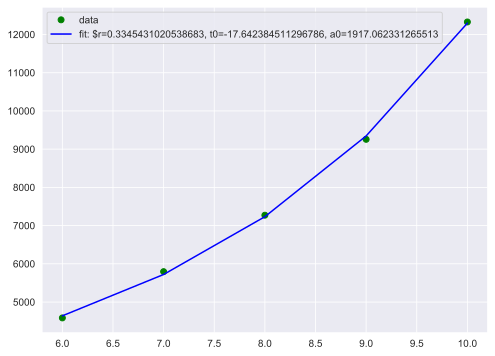

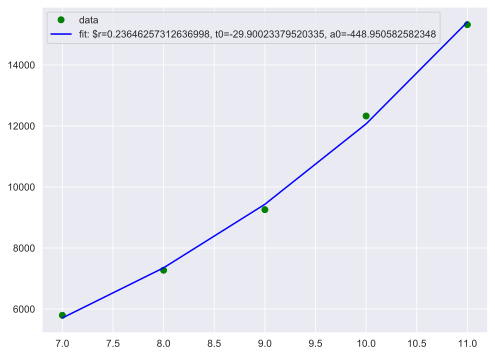

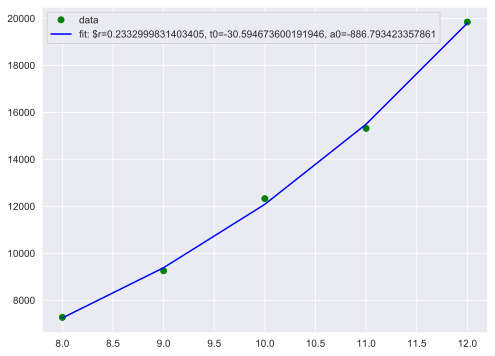

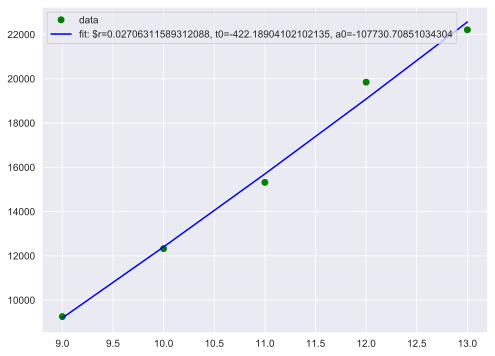

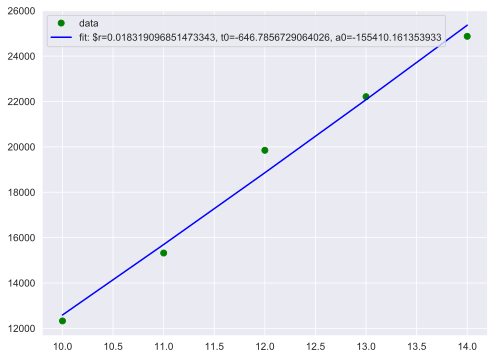

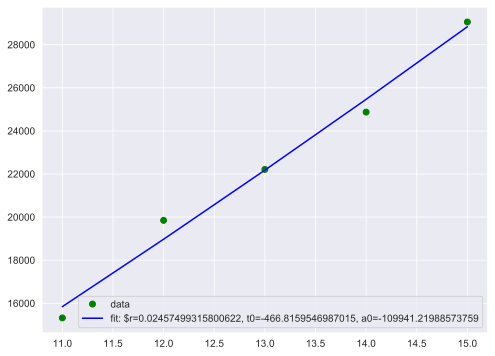

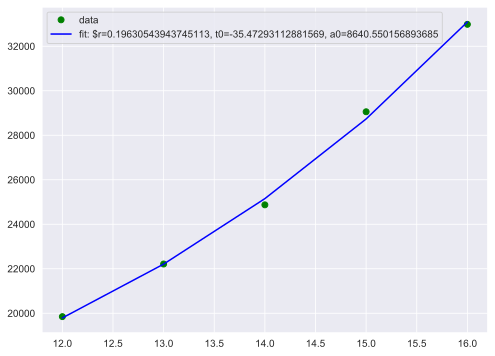

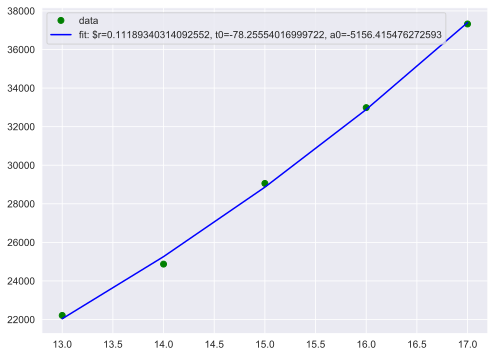

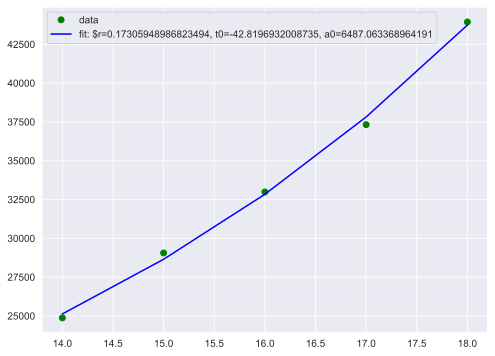

In [35]:
    
c = stack_country('Germany')
p = grow_rate_n_days(c['confirmed'][-20:])
#

In [36]:
p.tail(n=10)

,r,t0,a0,chi2
2020-03-18,0.2533,-26.8355,498.324,NaN
2020-03-19,0.334543,-17.6424,1917.06,NaN
2020-03-20,0.236463,-29.9002,-448.951,NaN
2020-03-21,0.2333,-30.5947,-886.793,NaN
2020-03-22,0.0270631,-422.189,-107731,NaN
2020-03-23,0.0183191,-646.786,-155410,NaN
2020-03-24,0.024575,-466.816,-109941,NaN
2020-03-25,0.196305,-35.4729,8640.55,NaN
2020-03-26,0.111893,-78.2555,-5156.42,NaN
2020-03-27,0.173059,-42.8197,6487.06,NaN


In [ ]:
p.at['r', 3] = 10

Log basics ...

In [ ]:
from math import log 
log(2)/log(0.5)

From https://en.wikipedia.org/wiki/Doubling_time
    
$$\Delta t = (t_2 - t_1) * \left(\frac{\log(2)}{\log
    \left(\frac{f(t_2)}{f(t_1)}\right)}\right)$$

In [ ]:
from math import log
def double_time_exponential(t1, t2, q1, q2):
    return (t2 - t1) * (log(2) / log(q2/q1) )

def growth_rate(double_time):
    return log(2)/double_time


t1, t2, q1, q2 = 0, 1, 1, 2
double_time_exponential(t1, t2, q1, q2), growth_rate(double_time_exponential(t1, t2, q1, q2) )

In [ ]:
2**(1/double_time_exponential(0, 1, 1, 21))

In [ ]:
2/math.exp(1)

In [ ]:
math.exp(0.5)/2

In [ ]:
math.exp(0.6931471805599453*4)